In [1]:
import gpytorch
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from types import SimpleNamespace as Namespace
from scipy.stats import multivariate_normal
from scipy.spatial.distance import cdist

In [2]:
import gp
import utils

In [3]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

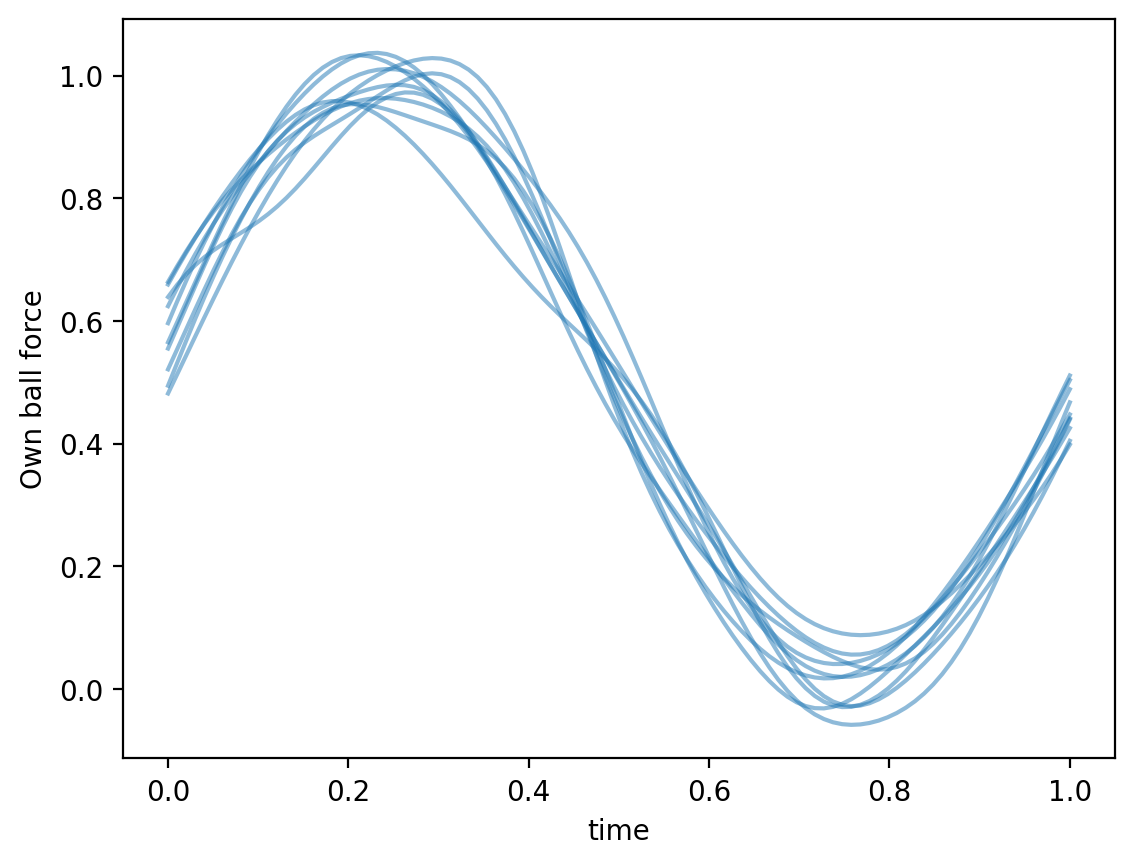

In [4]:
x = np.linspace(0, 1.0, 100)
mu = 0.5 + 0.5*np.cos(6*(x + 5))

alpha = 0.05
length = 0.1 

x2d = x.reshape((-1, 1))
sigma = alpha**2 * np.exp(-0.5 * cdist(x2d, x2d, 'sqeuclidean')/length**2)

n_sample = 10
y = np.random.multivariate_normal(mu, sigma, n_sample)

n_sample = 10
fig, ax = plt.subplots()
for y_ in y:
    ax.plot(x, y_, color="C0", alpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("Own ball force");

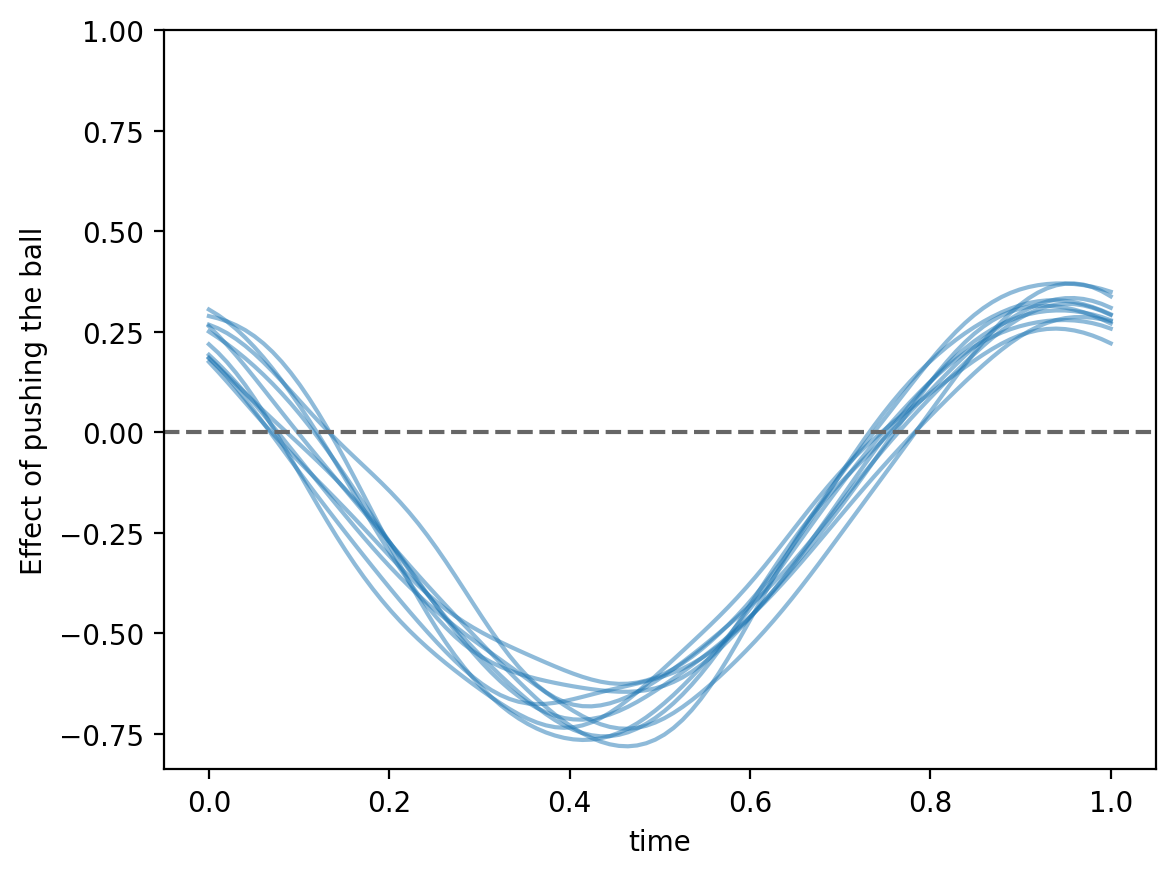

In [5]:
x = np.linspace(0, 1.0, 100).reshape((-1, 1))
mu = - 0.2 + 0.5*np.cos(6*(np.squeeze(x) - 2))

alpha = 0.05
length = 0.1

sigma = alpha**2 * np.exp(-0.5 * cdist(x, x, 'sqeuclidean')/length**2)

n_sample = 10
y = np.random.multivariate_normal(mu, sigma, n_sample)
fig, ax = plt.subplots()
for y_ in y:
    ax.plot(x, y_, color="C0", alpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("Effect of pushing the ball")
ax.set_ylim(None, 1);
ax.axhline(y=0.0, ls="--", color="0.4");

In [6]:
class Ball:
    def __init__(self, n_step):
        
        self.state = np.zeros(2)
        
        self.n_step = n_step
        self.x = np.linspace(0, 1.0, self.n_step)
        
        self.min_position, self.max_position = 0.0, 200.0
        self.max_speed = 10.0 
        
        self.friction_factor = 0.5
        
        self.own_force = None
        self.action_effect = None
        self.current_step = None

    @staticmethod
    def square_exponential_kernel(x, alpha, length):
        return alpha**2 * np.exp(-0.5 * cdist(x.reshape(-1, 1), x.reshape(-1, 1), 'sqeuclidean')/length**2)
    
    def sample_action_effect(self):
        
        x = self.x
        mu = - 0.2 + 0.5*np.cos(6*(x - 2))
        alpha = 0.05
        length = 0.1 
        sigma = self.square_exponential_kernel(x, alpha, length)
        return np.random.multivariate_normal(mu, sigma)
    
    def sample_own_force(self):
        
        x = self.x
        mu = 0.5 + 0.5*np.cos(6*(x + 5))
        alpha = 0.05
        length = 0.1
        sigma = self.square_exponential_kernel(x, alpha, length)
        return np.random.multivariate_normal(mu, sigma)

    def step(self, action: int):

        position, velocity = self.state
        velocity -= self.friction_factor * velocity
        velocity += self.action_effect[self.current_step]*action
        velocity += self.own_force[self.current_step] 
        
        velocity = np.clip(velocity, -self.max_speed, self.max_speed)
        
        position += velocity
        position = np.clip(position, self.min_position, self.max_position)
        
        self.state = position, velocity
        self.current_step += 1
        if self.current_step > self.n_step:
            raise ValueError("This wasn't supposed to be a step")
            
        return self.state
        
    def reset(self, seed=None):
                    
        if seed is not None:
            np.random.seed(seed)
            
        self.own_force = self.sample_own_force()
        self.action_effect = self.sample_action_effect()
        self.current_step = 0
        

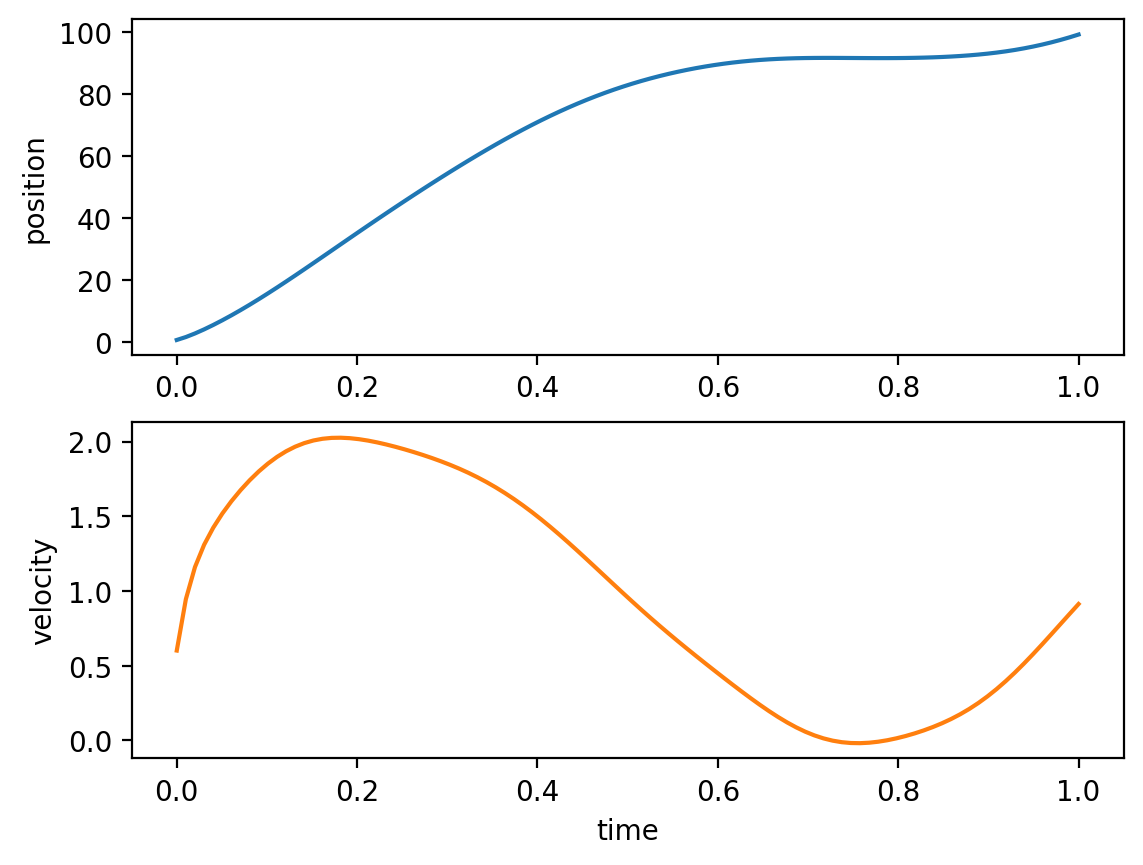

In [7]:
n_step = 100
ball = Ball(n_step)
ball.reset(seed=123456)
hist_pos, hist_vel = [], []
for i in range(n_step):
    pos, vel = ball.step(action=0)
    hist_pos.append(pos)
    hist_vel.append(vel)

fig, axes = plt.subplots(nrows=2)
x = np.linspace(0, 1, n_step)
axes[0].plot(x, hist_pos)
axes[0].set_ylabel("position")
axes[1].plot(x, hist_vel, color="C1")
axes[1].set_ylabel("velocity")
axes[1].set_xlabel("time");

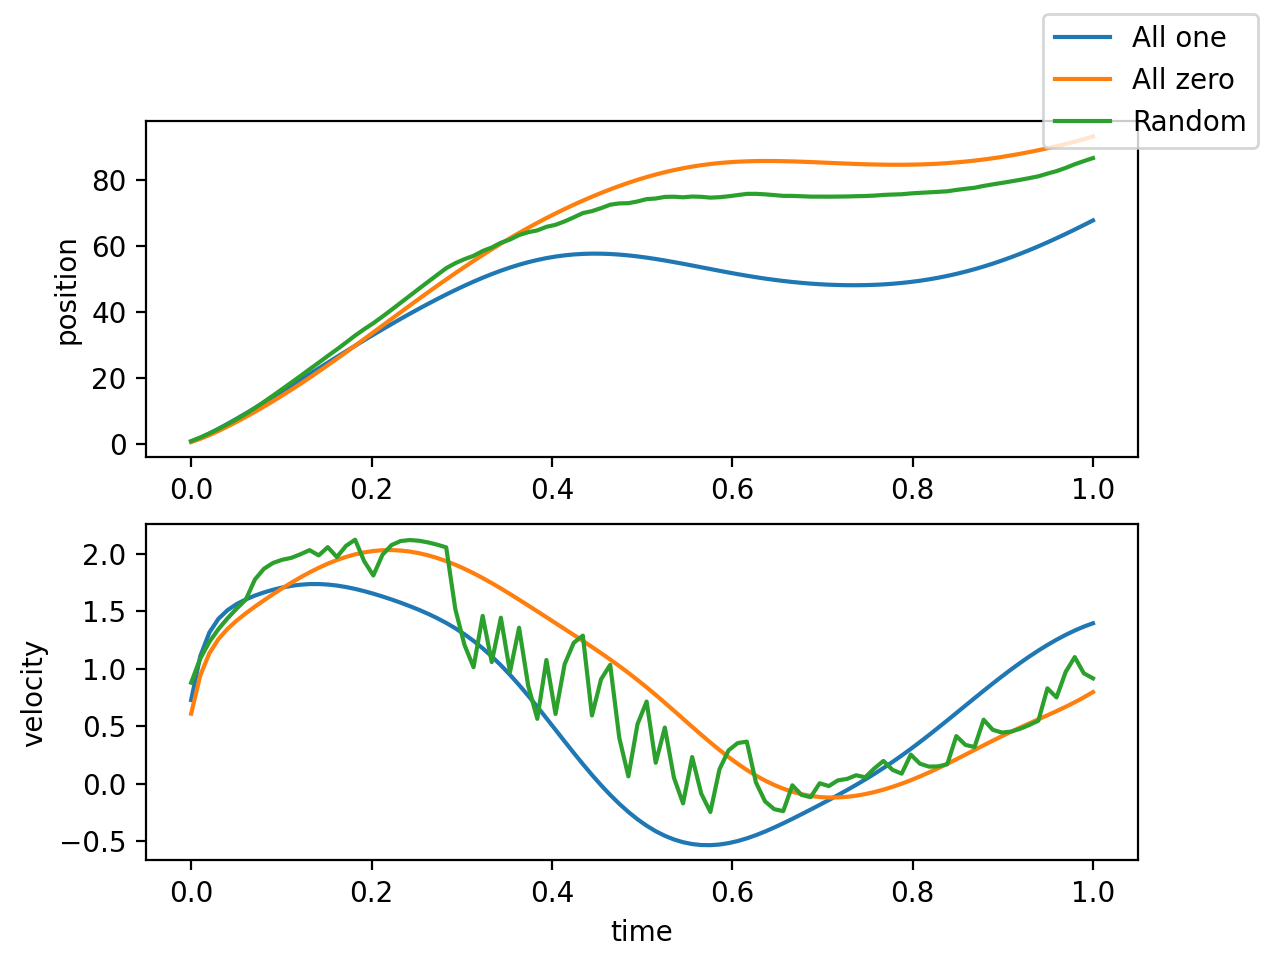

In [8]:
n_step = 100
all_hist_pos = []
all_hist_vel = []

policies = "all-one", "all-zero", "random"

for policy in policies:
    
    ball = Ball(n_step)
    ball.reset()
    hist_pos, hist_vel = [], []
    for i in range(n_step):
        if policy == "all-one":
            action = 1
        elif policy == "all-zero":
            action = 0
        elif policy == "random":
            action = np.random.choice([0, 1])
        else:
            raise ValueError
        pos, vel = ball.step(action=action)
        hist_pos.append(pos)
        hist_vel.append(vel)
        
    all_hist_pos.append(hist_pos)
    all_hist_vel.append(hist_vel)

fig, axes = plt.subplots(nrows=2)
for i in range(len(policies)):
    label = policies[i].replace("-", " ").capitalize()
    pos = all_hist_pos[i]
    vel = all_hist_vel[i]
    x = np.linspace(0, 1, n_step)
    axes[0].plot(x, pos, color=f"C{i}", label=label)
    axes[1].plot(x, vel, color=f"C{i}")
    axes[0].set_ylabel("position")
    axes[1].set_ylabel("velocity");
    axes[1].set_xlabel("time");
    
    
fig.legend();

In [9]:
def square_exponential_kernel(x, alpha, length):
    return alpha**2 * np.exp(-0.5 * cdist(x.reshape(-1, 1), x.reshape(-1, 1), 'sqeuclidean')/length**2)

def sample_action_effect(t, size=1):

    mu = - 0.2 + 0.5*np.cos(6*(t - 2))
    alpha = 0.05
    length = 0.1
    sigma = square_exponential_kernel(t, alpha, length)
    return np.random.multivariate_normal(mu, sigma, size=size)

def sample_own_force(t, size=1):

    mu = 0.5 + 0.5*np.cos(6*(t + 5))
    alpha = 0.05
    length = 0.1
    sigma = square_exponential_kernel(t, alpha, length)
    return np.random.multivariate_normal(mu, sigma, size=size)

In [44]:
n_timestep = 100
n_velocity = 100
n_action = 2

n_sample = 50

timestep = np.linspace(0, 1.0, n_timestep)
velocity = np.linspace(-3, 3, n_velocity)
action = np.arange(n_action)

min_position, max_position = 0.0, 200.0
max_velocity = 10.0

friction_factor = 0.5

# transition dynamics
# p[s, a, s1] of size (s_N, a_N, s_N)


In [45]:
own_force = sample_own_force(timestep, size=n_sample)
action_effect = sample_action_effect(timestep, size=n_sample)

In [46]:
print(own_force.shape)
print(action_effect.shape)

(50, 100)
(50, 100)


In [47]:
space = [(v, t) for t in timestep for v in velocity]
size_space = len(space)

In [64]:
timestep_list = list(timestep)

p = np.zeros((size_space, n_action, n_velocity))
for i, (v, t) in enumerate(space):
    t_index = timestep_list.index(t)
    for a in action:
        new_v = np.zeros(n_sample)
        new_v += v - friction_factor*v
        new_v += action_effect[:, t_index]*a
        new_v += own_force[:, t_index]
        new_v = np.clip(new_v, -max_velocity, max_velocity)
        hist, bins = np.histogram(new_v, bins=list(velocity) + [velocity[-1] + (velocity[-1] - velocity[-2])])
        density = hist / np.sum(hist)
        p[i, a, :] = density

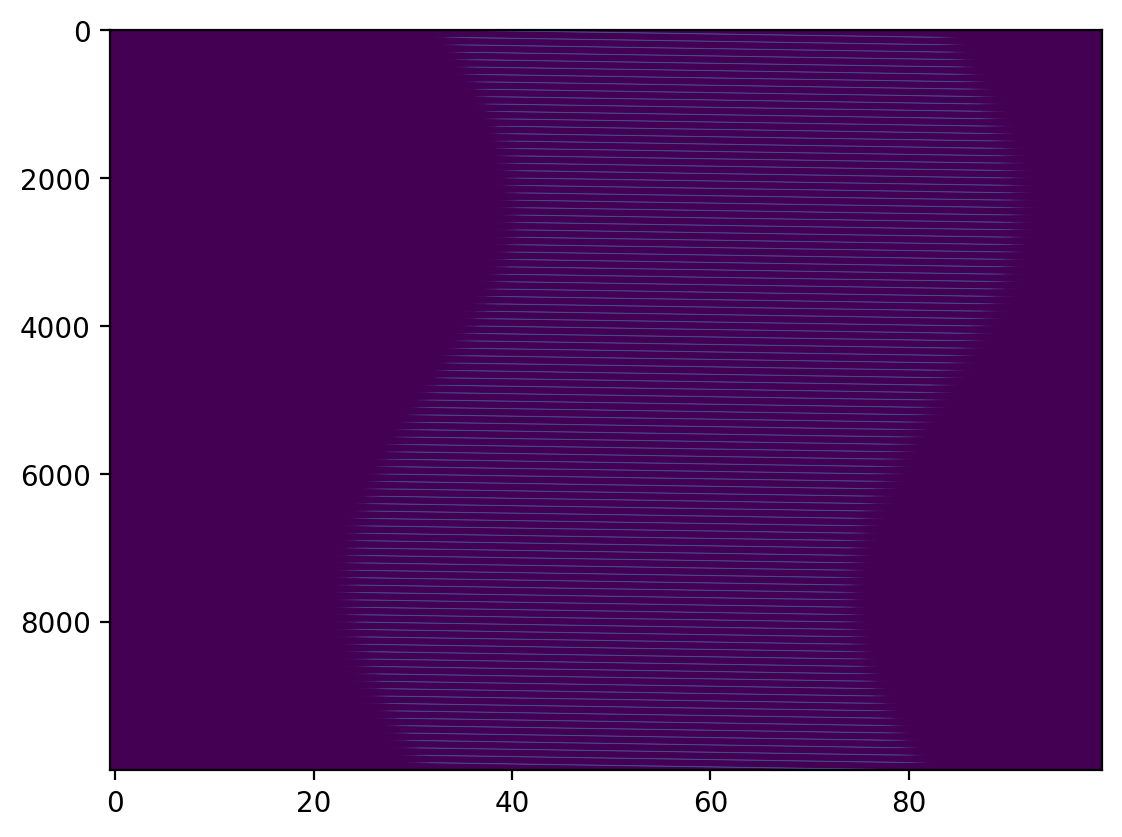

In [65]:
plt.imshow(p[:, 0, :], aspect="auto")

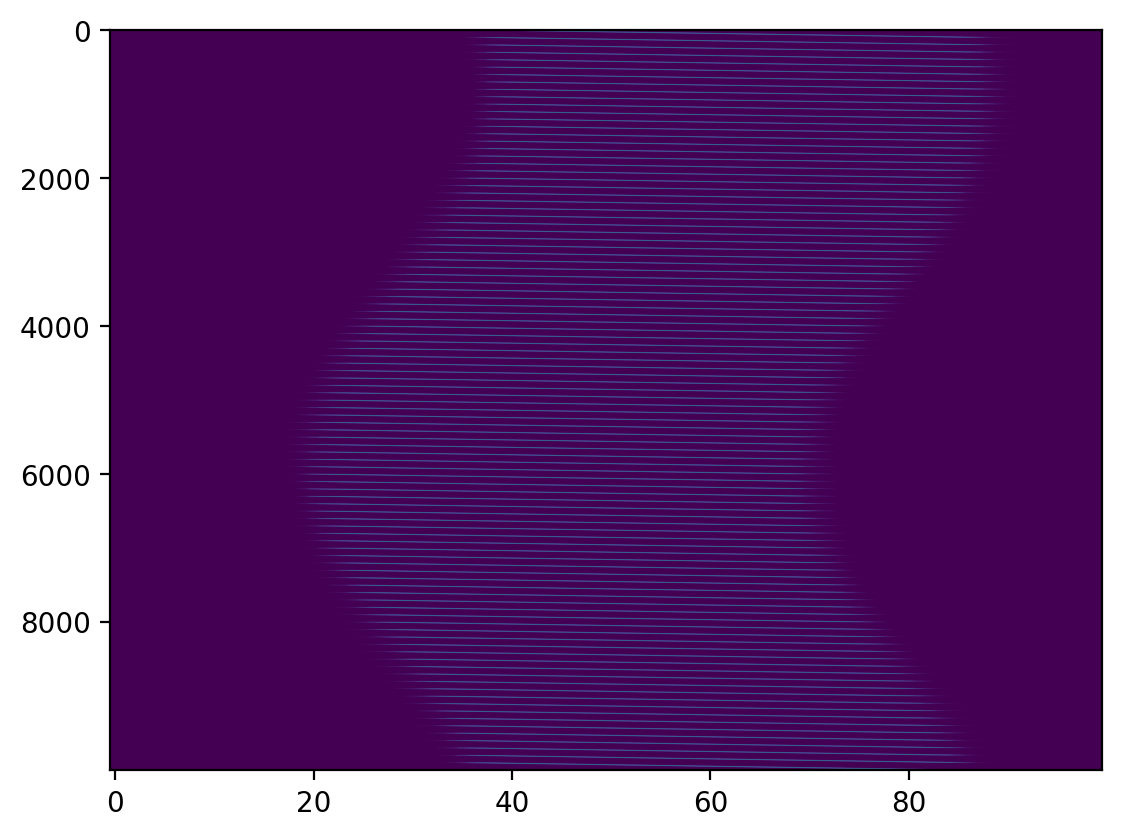

In [66]:
plt.imshow(p[:, 1, :], aspect="auto")

In [67]:
est = np.ones((size_space, n_action, n_velocity))
for i in range(n_velocity):
    est[:, :, i] /= np.sum(est[:, :, i])

In [68]:
est

array([[[5.e-05, 5.e-05, 5.e-05, ..., 5.e-05, 5.e-05, 5.e-05],
        [5.e-05, 5.e-05, 5.e-05, ..., 5.e-05, 5.e-05, 5.e-05]],

       [[5.e-05, 5.e-05, 5.e-05, ..., 5.e-05, 5.e-05, 5.e-05],
        [5.e-05, 5.e-05, 5.e-05, ..., 5.e-05, 5.e-05, 5.e-05]],

       [[5.e-05, 5.e-05, 5.e-05, ..., 5.e-05, 5.e-05, 5.e-05],
        [5.e-05, 5.e-05, 5.e-05, ..., 5.e-05, 5.e-05, 5.e-05]],

       ...,

       [[5.e-05, 5.e-05, 5.e-05, ..., 5.e-05, 5.e-05, 5.e-05],
        [5.e-05, 5.e-05, 5.e-05, ..., 5.e-05, 5.e-05, 5.e-05]],

       [[5.e-05, 5.e-05, 5.e-05, ..., 5.e-05, 5.e-05, 5.e-05],
        [5.e-05, 5.e-05, 5.e-05, ..., 5.e-05, 5.e-05, 5.e-05]],

       [[5.e-05, 5.e-05, 5.e-05, ..., 5.e-05, 5.e-05, 5.e-05],
        [5.e-05, 5.e-05, 5.e-05, ..., 5.e-05, 5.e-05, 5.e-05]]])

In [69]:
pos = 0
v = 0

a = 0

for t in timestep:
    space_index = space.index((v, t))
    vel = np.random.choice(velocity, p=p[space_index, a])
    pos += vel



ValueError: (0, 0.0) is not in list

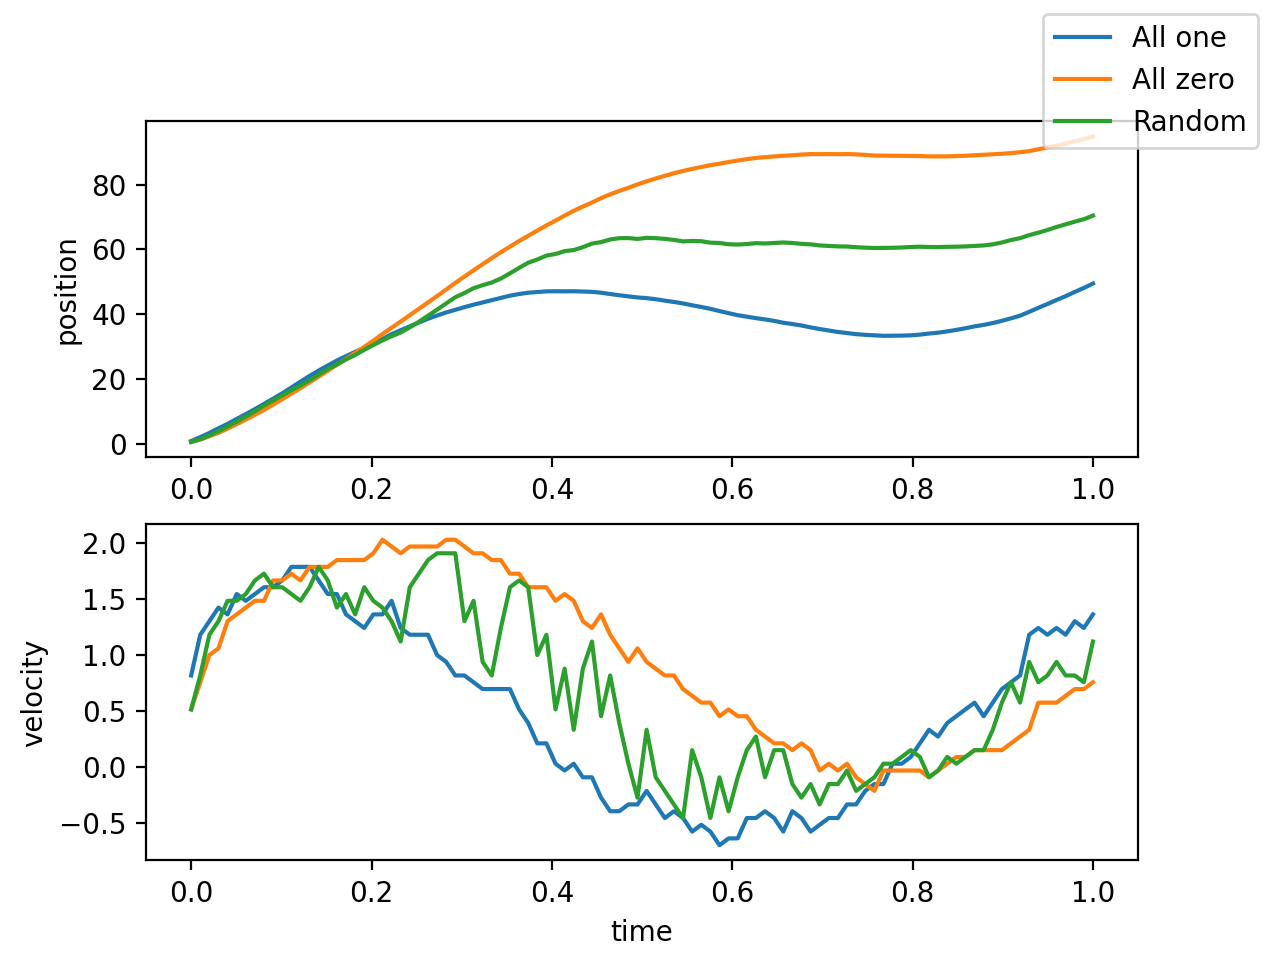

In [72]:
all_hist_pos = []
all_hist_vel = []

policies = "all-one", "all-zero", "random"

for policy in policies:
    hist_pos, hist_vel = [], []
    pos, v = 0, velocity[np.absolute(velocity).argmin()]
    for t in timestep:
        if policy == "all-one":
            a = 1
        elif policy == "all-zero":
            a = 0
        elif policy == "random":
            a = np.random.choice([0, 1])
        else:
            raise ValueError
        space_index = space.index((v, t))
        p_ = p[space_index, a]
        v = np.random.choice(velocity, p=p_)
        pos += v
        hist_pos.append(pos)
        hist_vel.append(v)

    all_hist_pos.append(hist_pos)
    all_hist_vel.append(hist_vel)

fig, axes = plt.subplots(nrows=2)
for i in range(len(policies)):
    label = policies[i].replace("-", " ").capitalize()
    pos = all_hist_pos[i]
    vel = all_hist_vel[i]
    x = np.linspace(0, 1, n_step)
    axes[0].plot(x, pos, color=f"C{i}", label=label)
    axes[1].plot(x, vel, color=f"C{i}")
    axes[0].set_ylabel("position")
    axes[1].set_ylabel("velocity")
    axes[1].set_xlabel("time")

fig.legend();

In [73]:
hist_pos, hist_vel = [], []
pos, v = 0, velocity[np.absolute(velocity).argmin()]
policy = "all-zero"

velocity_list = list(velocity)

for t in timestep:
    if policy == "all-one":
        a = 1
    elif policy == "all-zero":
        a = 0
    elif policy == "random":
        a = np.random.choice([0, 1])
    else:
        raise ValueError
    space_index = space.index((v, t))
    p_ = p[space_index, a]
    new_v = np.random.choice(velocity, p=p_)
    new_pos = pos + v

    # est_new_v =  new_pos - pos
    index_v = velocity_list.index(v)
    index_new_v = velocity_list.index(new_v)
    p_v_given_phi = est[index_v, a, index_new_v]
    p_phi_given_v = 0 # ? using Dirlichet distribution??

    hist_pos.append(new_pos)
    hist_vel.append(new_v)

    pos = new_pos
    v = new_v

AttributeError: 'numpy.ndarray' object has no attribute 'index'